In [14]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import jax.numpy as jnp

import jax
import jax.numpy as jnp
from flax import nnx

digits = load_digits()

splits = train_test_split(digits.images,digits.target, random_state=0)

images_train, images_test, label_train, label_test = map(jnp.asarray, splits)

print(f"{images_train.shape=}")
print(f"{images_test.shape=}")

latent_dim = 8
beta = 0.1

images_train.shape=(1347, 8, 8)
images_test.shape=(450, 8, 8)


In [15]:
class Encoder(nnx.Module):
  def __init__(self, input_size: int, intermediate_size: int, output_size: int,
               *, rngs: nnx.Rngs):
    self.rngs = rngs
    self.linear = nnx.Linear(input_size, intermediate_size, rngs=rngs)
    self.linear_mean = nnx.Linear(intermediate_size, output_size, rngs=rngs)
    self.linear_std = nnx.Linear(intermediate_size, output_size, rngs=rngs)

  def __call__(self, x: jax.Array) -> tuple[jax.Array, jax.Array, jax.Array]:
    x = self.linear(x)
    x = jax.nn.relu(x)

    mean = self.linear_mean(x)
    std = jnp.exp(self.linear_std(x))

    key = self.rngs.noise()
    z = mean + std * jax.random.normal(key, mean.shape)
    return z, mean, std

In [16]:
class Decoder(nnx.Module):
  def __init__(self, input_size: int, intermediate_size: int, output_size: int,
               *, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(input_size, intermediate_size, rngs=rngs)
    self.linear2 = nnx.Linear(intermediate_size, output_size, rngs=rngs)

  def __call__(self, z: jax.Array) -> jax.Array:
    z = self.linear1(z)
    z = jax.nn.relu(z)
    logits = self.linear2(z)
    return logits

In [17]:
class VAE(nnx.Module):
  def __init__(
    self,
    image_shape: tuple[int, int],
    hidden_size: int,
    latent_size: int,
    *,
    rngs: nnx.Rngs
  ):
    self.image_shape = image_shape
    self.latent_size = latent_size
    input_size = image_shape[0] * image_shape[1]
    self.encoder = Encoder(input_size, hidden_size, latent_size, rngs=rngs)
    self.decoder = Decoder(latent_size, hidden_size, input_size, rngs=rngs)

  def __call__(self, x: jax.Array) -> tuple[jax.Array, jax.Array, jax.Array]:
    x = jax.vmap(jax.numpy.ravel)(x)  # flatten
    z, mean, std = self.encoder(x)
    logits = self.decoder(z)
    logits = jnp.reshape(logits, (-1, *self.image_shape))
    return logits, mean, std

In [18]:
import optax

@nnx.jit
def train_step(model: VAE, optimizer: nnx.Optimizer, x: jax.Array):
  loss, grads = nnx.value_and_grad(vae_loss)(model, x)
  optimizer.update(grads)
  return loss

In [19]:
images_normed = (digits.images / 16) > 0.5
splits = train_test_split(images_normed, random_state=0)
images_train, images_test = map(jnp.asarray, splits)

def vae_loss(model: VAE, x: jax.Array):
  logits, mean, std = model(x)

  kl_loss = jnp.mean(0.5 * jnp.mean(
      -jnp.log(std ** 2) - 1.0 + std ** 2 + mean ** 2, axis=-1))
  reconstruction_loss = jnp.mean(
    optax.sigmoid_binary_cross_entropy(logits, x)
  )
  return reconstruction_loss + beta * kl_loss

model = VAE(
  image_shape=(8, 8),
  hidden_size=100,
  latent_size=latent_dim,
  rngs=nnx.Rngs(0, noise=1),
)

optimizer = nnx.Optimizer(model, optax.adam(1e-3))

for epoch in range(2000):
  loss = train_step(model, optimizer, images_train)
  if epoch % 500 == 0:
    print(f'Epoch {epoch} loss: {loss}')

Epoch 0 loss: 0.7508810758590698
Epoch 500 loss: 0.26907169818878174
Epoch 1000 loss: 0.2543070912361145
Epoch 1500 loss: 0.2479756474494934


In [20]:
vae_encoder = model.encoder

In [21]:
# Encode training and test images
encoded_train, _, _ = jax.vmap(vae_encoder)(images_train.reshape(-1, 64))  # Flatten images
encoded_test, _, _ = jax.vmap(vae_encoder)(images_test.reshape(-1, 64))


In [22]:
class SimpleNN(nnx.Module):

  def __init__(self, n_features: int = 64, n_hidden: int = 100, n_targets: int = 10,
               *, rngs: nnx.Rngs):
    self.n_features = n_features
    self.layer1 = nnx.Linear(n_features, n_hidden, rngs=rngs)
    self.layer2 = nnx.Linear(n_hidden, n_hidden, rngs=rngs)
    self.layer3 = nnx.Linear(n_hidden, n_targets, rngs=rngs)

  def __call__(self, x):
    x = x.reshape(x.shape[0], self.n_features) # Flatten images.
    x = nnx.selu(self.layer1(x))
    x = nnx.selu(self.layer2(x))
    x = self.layer3(x)
    return x

In [23]:
# Define classifier model
classifier = SimpleNN(n_features=latent_dim, n_hidden=100, n_targets=10, rngs=nnx.Rngs(0))

# Define loss and optimizer
optimizer_nn = nnx.Optimizer(classifier, optax.adam(1e-3))

def classifier_loss_fn(model: SimpleNN, x: jax.Array, y: jax.Array):
    logits = model(x)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean()
    return loss, logits

@nnx.jit
def train_classifier_step(model: SimpleNN, optimizer: nnx.Optimizer, x: jax.Array, y: jax.Array):
    loss, grads = nnx.value_and_grad(classifier_loss_fn, has_aux=True)(model, x, y)
    optimizer.update(grads)
    return loss

# Train the classifier
for epoch in range(300):
    train_classifier_step(classifier, optimizer_nn, encoded_train, label_train)
    if epoch % 50 == 0:  # Print metrics.
      loss, _ = classifier_loss_fn(classifier, encoded_test, label_test)
      print(f"epoch {epoch}: loss={loss:.2f}")


epoch 0: loss=2.70
epoch 50: loss=0.65
epoch 100: loss=0.57
epoch 150: loss=0.53
epoch 200: loss=0.51
epoch 250: loss=0.49


In [24]:
label_pred = classifier(encoded_test).argmax(axis=1)
num_matches = jnp.count_nonzero(label_pred == label_test)
num_total = len(label_test)
accuracy = num_matches / num_total
print(f"{num_matches} labels match out of {num_total}:"
      f" accuracy = {num_matches/num_total:%}")

379 labels match out of 450: accuracy = 84.222221%


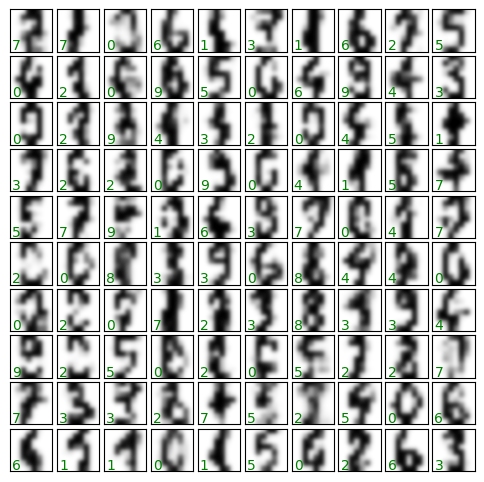

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# generate new images by sampling the latent space
z = np.random.normal(scale=1.5, size=(100, model.latent_size))
labels_gen = classifier(z).argmax(axis=1)
logits = model.decoder(z).reshape(-1, 8, 8)
images_gen = nnx.sigmoid(logits)

fig, axes = plt.subplots(10, 10, figsize=(6, 6),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(images_gen[i], cmap='binary', interpolation='gaussian')
    color = 'green'
    ax.text(0.05, 0.05, str(labels_gen[i]), transform=ax.transAxes, color=color)